importing required libraries


In [3]:
import os
import urllib.request
import tarfile
from fastai.vision.all import *
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import pydicom

Function to Create Binary Image Maps

This function processes each image and converts it into a binary format based on non-zero values in the red and green channels. The processed images are saved back to their original locations in grayscale.


In [4]:
def create_map(folder):
    for f in tqdm(os.listdir(folder)):
        file = os.path.join(folder, f)
        if not os.path.isfile(file):
            continue
        img = plt.imread(file)
        img2 = (img[:,:,0]!=0) | (img[:,:,1]!=0)
        plt.imsave(file, img2, cmap='gray')

Clearing gpu cache to prevent any leaks and ensuring sufficient memory is there

In [5]:
torch.cuda.empty_cache()

In [6]:
#here we create a directory for the dataset
data_dir = 'flowers'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

downloading of dataset images, segmentation masks and image labels

In [7]:
# Download the images
img_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
img_file_path = os.path.join(data_dir, "102flowers.tgz")
urllib.request.urlretrieve(img_url, img_file_path)

# Extract the images
with tarfile.open(img_file_path, 'r:gz') as tar:
    tar.extractall(path=data_dir)

# Download the image labels
labels_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
labels_file_path = os.path.join(data_dir, "imagelabels.mat")
urllib.request.urlretrieve(labels_url, labels_file_path)

# Download the segmentations
seg_url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz"
seg_file_path = os.path.join(data_dir, "102segmentations.tgz")
urllib.request.urlretrieve(seg_url, seg_file_path)

# Extract the segmentations
with tarfile.open(seg_file_path, 'r:gz') as tar:
    tar.extractall(path=data_dir)

creation of segmentation masks

In [8]:
create_map('./flowers/segmim/')

100%|██████████| 8189/8189 [01:13<00:00, 111.00it/s]


In [9]:
images_path = Path(data_dir) / 'jpg'
masks_path = Path(data_dir) / 'segmim'

In [10]:
# Function to get the mask file paths
def get_msk(fn):
    return masks_path / f"segmim_{fn.stem[-5:]}.jpg"

# Function to label the data
def label_func(fn):
    return get_msk(fn)

Calling `SegmentationDataLoaders` which Prepares and loads data for segmentation tasks, ensuring images and their corresponding masks are correctly processed and batched for model training.


In [11]:
# Load the data
dls = SegmentationDataLoaders.from_label_func(
    images_path,
    get_image_files(images_path),
    label_func=label_func,
    codes=["background", "flower"],
    item_tfms=Resize(224),
    batch_tfms=IntToFloatTensor(div_mask=255),
    bs = 2
)

Here we load the model freeze the layers and then add an extra layer of our own

In [12]:
# Define the model with an additional layer
learn = unet_learner(dls, resnet50, metrics=Dice(), pretrained=True)
learn.freeze()
learn.model[-1].add_module('custom_layer', nn.ReLU())

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s] 


In [13]:
learn.summary()

DynamicUnet (Input shape: 2 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 64 x 112 x 112  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     2 x 64 x 56 x 56    
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     2 x 256 x 56 x 56   
Conv2d                                    16384      False     
BatchNorm2d                        

Next we have to find the optimal learning rate for the model

SuggestedLRs(valley=3.311311229481362e-05)

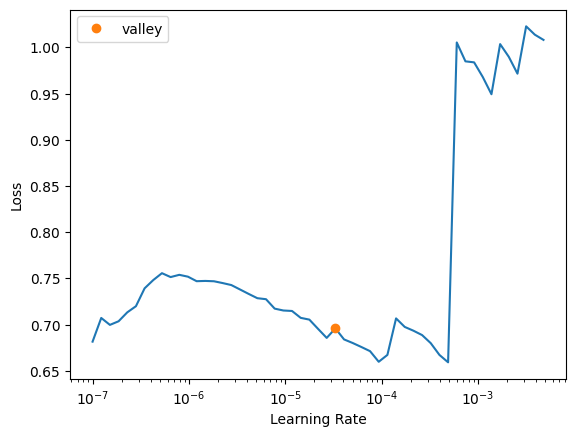

In [14]:
learn.freeze()
learn.lr_find(end_lr=100) #used to fin the best possible learning rate

Making use of fit one cycle method to acheive faster results

In [15]:
learn.fit_one_cycle(10, 1.4454397387453355e-05) #this will dynamically adjust learning rate thus is faster compared to other methods like learn.finetune()

epoch,train_loss,valid_loss,dice,time
0,0.267746,0.288958,0.879133,24:05
1,0.234643,0.231503,0.897799,24:04
2,0.227665,0.217492,0.895540,24:02
3,0.209092,0.206981,0.901468,24:01
4,0.209454,0.226266,0.892857,24:02
5,0.188380,0.208848,0.901258,24:01
6,0.199542,0.268871,0.892206,24:02
7,0.184281,0.245336,0.898642,24:03
8,0.163464,0.219937,0.900067,24:03
9,0.175842,0.221957,0.899396,24:03


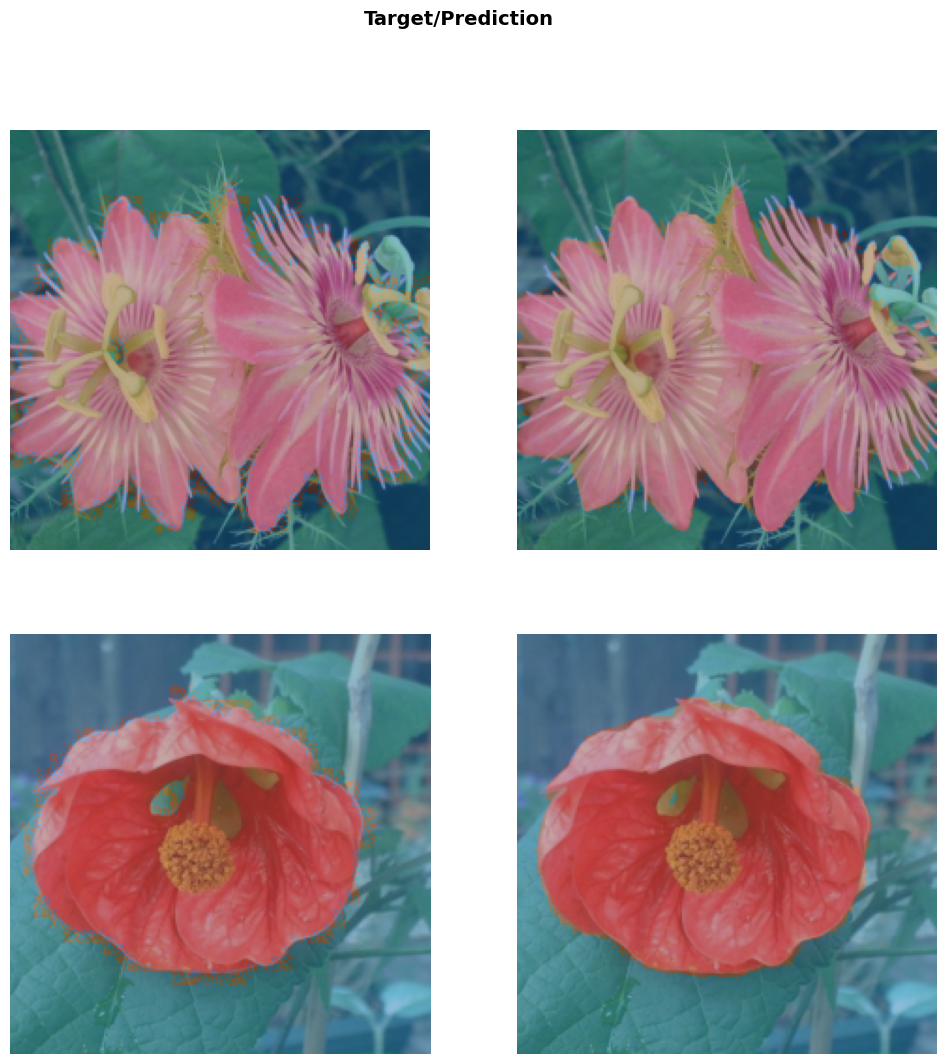

In [16]:
# Evaluate the model
learn.show_results(max_n=6, figsize=(12, 12))

In [17]:
learn.validate(1) #model validation

(#2) [0.2219569981098175,0.8993962130960633]